In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

import energydatamodel as edm
import enflow as ef

from Utilities.PV_AC_Output import PV_AC_Output
from Utilities.Data_import import calculate_retail_price
from Utilities import Plot, KPI

from Models.PV_BESS_LP_opt import PV_BESS_LP_solver
from Models.PV_BESS_LP_time_horizon import PV_BESS_LP_Time_horizon_v2

In [2]:
df_demand = pd.read_csv("data/electricity_demand.csv", index_col=0, parse_dates=True)
df_meteo = pd.read_csv("data/meteo_data.csv", index_col=0, parse_dates=True)

### 1) Create energy system

In [3]:
pv_system = edm.PVSystem(name="my_pvsystem",
                         surface_tilt=30,
                         surface_azimuth=180,
                         capacity=4,
                         module_type='glass_polymer',
                         module_parameters={'gamma_pdc': -0.004})

bess_system = edm.Battery(name="my_battery",
                          storage_capacity=8,   
                       min_soc=0.1,               
                       max_charge=0.5,           
                       max_discharge=0.5,     
                       charge_efficiency=1, 
                       discharge_efficiency=1)

building = edm.Building(name="my_building", 
                        location=edm.Location(longitude=18.0686, latitude=59.3293, tz='Europe/Stockholm'),
                        assets=[pv_system, bess_system])

In [9]:
# Calculate pv output data
pvlib_system = pv_system.to_pvlib()
pvlib_location = building.location.to_pvlib()

modelchain = pvlib.modelchain.ModelChain(pvlib_system, pvlib_location, dc_model='pvwatts', aoi_model='no_loss', spectral_model='no_loss')
power = modelchain.run_model(pvlib_location.get_clearsky(times=df_demand.index)).results.dc


<Axes: >

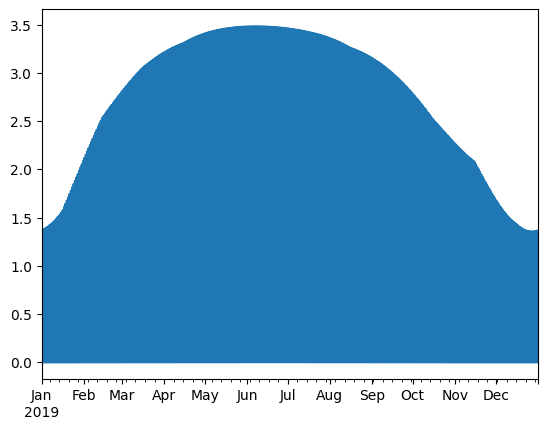

In [10]:
power.plot()

In [6]:
if pv_system.module_parameters is None: 
    print("s")

In [7]:
#Evaluation of the PV production/Users/sebaheg/Documents/electricity_demand.csv
df_inputs['PVProduction'] = PV_AC_Output(
                                    PV_rated_power=pv_syst.capacity,
                                    start_day=start_day,
                                    end_day=end_day,
                                    GHI=df_meteo['SolarGHI'].values,
                                    clear_sky_condition=False
)

#Create the Dataset
PVBessDataset = ef.Dataset(name='Building 1',
                           energy_system=building,
                           description='PV-BESS system',
                           data=df_inputs

SyntaxError: incomplete input (677401646.py, line 14)